# Google Colab Setup 

Please run the code below to mount drive if you are running on colab.

Please ignore if you are running on your local machine.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/MiniGPT/

# Language Modeling and Transformers

The project will consist of two broad parts. 

1. **Baseline Generative Language Model**: We will train a simple Bigram language model on the text data. We will use this model to generate a mini story. 
2. **Implementing Mini GPT**: We will implement a mini version of the GPT model layer by layer and attempt to train it on the text data. You will then load pretrained weights provided and generate a mini story. 

## Some general instructions 

1. Please keep the name of layers consistent with what is requested in the `model.py` file for each layer, this helps us test in each function independently. 
2. Please check to see if the bias is to be set to false or true for all linear layers (it is mentioned in the doc string)
3. As a general rule please read the docstring well, it contains information you will need to write the code. 
4. All configs are defined in `config.py` for the first part while you are writing the code do not change the values in the config file since we use them to test. Once you have passed all the tests please feel free to vary the parameter as you please.
5. You will need to fill in the `train.py` and run it to train the model. If you are running into memory issues please feel free to change the `batch_size` in the `config.py` file. If you are working on Colab please make sure to use the GPU runtime and feel free to copy over the training code to the notebook. 

In [86]:
!pip install numpy torch tiktoken wandb einops # Install all required packages

In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import torch
import tiktoken

In [89]:
from model import BigramLanguageModel, SingleHeadAttention, MultiHeadAttention, FeedForwardLayer, LayerNorm, TransformerLayer, MiniGPT
from config import BigramConfig, MiniGPTConfig
import tests

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [91]:
path_to_bigram_tester = "./pretrained_models/bigram_tester.pt" # Load the bigram model with name bigram_tester.pt
path_to_gpt_tester = "./pretrained_models/minigpt_tester.pt" # Load the gpt model with name minigpt_tester.pt

##  Bigram Language Model (10 points)

A bigram language model is a type of probabilistic language model that predicts a word given the previous word in the sequence. The model is trained on a text corpus and learns the probability of a word given the previous word.



### Implement the Bigram model (5 points)

Please complete the `BigramLanguageModel` class in model.py. We will model a Bigram language model using a simple MLP with one hidden layer. The model will take in the previous word index and output the logits over the vocabulary for the next word.

In [92]:
# Test implementation for Bigram Language Model
model = BigramLanguageModel(BigramConfig)
tests.check_bigram(model,path_to_bigram_tester, device)

Maximum absolute difference: 0.0


'TEST CASE PASSED!!!'

### Training the Bigram Language Model (2.5 points)

Complete the code in `train.py` to train the Bigram language model on the text data. The loss and the optimizer have been provided for you. Please provide plots for both the training and validation in the cell below.

Some notes on the training process:

1. You should be able to train the model slowly on your local machine.
2. Training it on Colab will help with speed.
3.  <span style="color:red">To get full points for this section it is sufficient to show that the loss is decreasing over time</span>. You should see it saturate to a value close to around 5-6 but as long as you see it decreasing then saturating you should be good.
4. Please log the loss curves either on wandb, tensorboard or any other logger of your choice and please attach them below.

### Train and Valid Plots


** Show the training and validation loss plots **

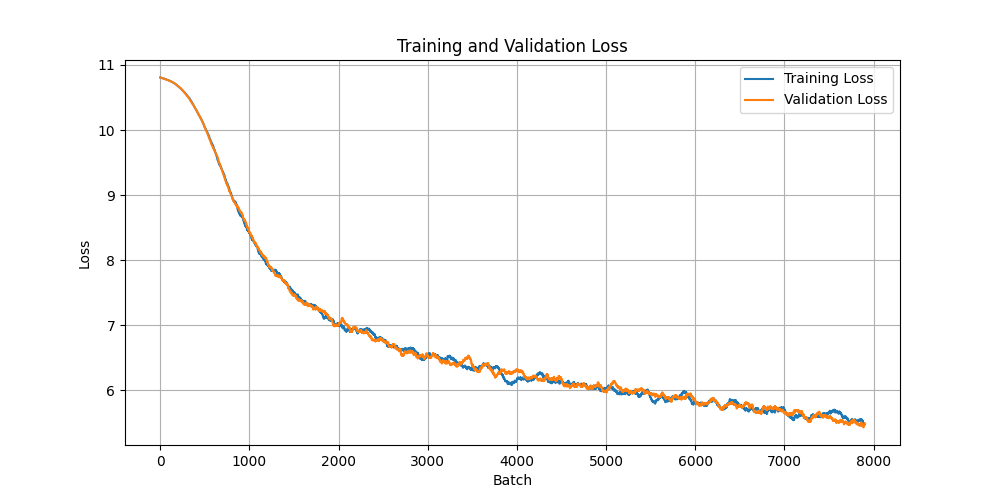

In [93]:
from IPython.display import Image

# Path to the saved figure
training_loss_figure_path = "training_validation_loss_bigram.png"

# Display the saved figure
display(Image(training_loss_figure_path))

### Generation (2.5 points)

Complete the code in `generate.py` to generate a mini story using the trained Bigram language model. The model will take in the previous word index and output the next word index. You can use the `generate_sentence` function to generate a mini story.

Start with the following seed sentence: 
    
    `"once upon a time"`
    

In [98]:
tokenizer = tiktoken.get_encoding("gpt2")

In [99]:
gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    )
)

Generating text starting with: torch.Size([4])
Once upon a time#"!"!""!#"#$"!!"$!$$!!$!$!$#!$$"$##$##!"#$"$$$!$!"#!"""!"!"!!$"$!!####$$$#$"$#$!$#"$#$$$$"$"$#"$#$!$#"!$#$!$!!###!#"##$"!#$$!"$"!#"""##!$""!#$"$#"!$"!#$$#$#!#!!$"$!$#"!"#""$$"$#!"$$#!"$""##!!#$"!##!"!


/Users/laurenmizner/Desktop/MiniGPT3/model.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A list of integers (tokens) representing the generated tokens.


### Observation and Analysis

Please answer the following questions. 

1. What can we say about the generated text in terms of grammar and coherence? 

For some reason the generated text is all punctuation, so the grammar and coherence here is pretty non-existent. 

2. What are the limitations of the Bigram language model?

A bigram model has pretty limited context as it only considers the previous token when predicting the next token. Bigram models typically do not capture the nuances and intricacies of language as effectively as a complex model would. 

3. If the model is scaled with more parameters do you expect the bigram model to get substantially better? Why or why not?

Even if the model was scaled, it may not perform substantially better, due to the overall limitations of bigram models. More parameters still doesn't address the limitation of only considering the previous token when predicition the next. It still lacks the ability to capture the overall context of the text. 

## Mini GPT (90 points)

We will not implement a decoder style transformer model like we discussed in lecture, which is a scaled down version of the [GPT model](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf). 

All the model components follow directly from the original [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. The only difference is we will use prenormalization and learnt positional embeddings instead of fixed ones. But you will not need to worry about these details!

We will now implement each layer step by step checking if it is implemented correctly in the process. We will finally put together all our layers to get a fully fledged GPT model. 

<span style="color:red">Later layers might depend on previous layers so please make sure to check the previous layers before moving on to the next one.</span>

### Single Head Causal Attention (20 points)

We will first implement the single head causal attention layer. This layer is the same as the scaled dot product attention layer but with a causal mask to prevent the model from looking into the future.

Recall that Each head has a Key, Query and Value Matrix and the scaled dot product attention is calculated as : 

\begin{equation}
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\end{equation}

where $d_k$ is the dimension of the key matrix.

Figure below from the original paper shows how the layer is to be implemented.

![image](./Images/Single_Head.png)

Image credits: [Attention is All You Need Paper](https://arxiv.org/abs/1706.03762)

Please complete the `SingleHeadAttention` class in `model.py`

In [70]:
model = SingleHeadAttention(MiniGPTConfig.embed_dim, MiniGPTConfig.embed_dim//4, MiniGPTConfig.embed_dim//4) # configs are set as such for testing do not modify

tests.check_singleheadattention(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Multi Head Attention (10 points)

Now that we have a single head working, we will now scale this across multiple heads, remember that with multihead attention we compute perform head number of parallel attention operations. We then concatenate the outputs of these parallel attention operations and project them back to the desired dimension using an output linear layer.

Figure below from the original paper shows how the layer is to be implemented.

![image](./Images/MultiHead.png)

Image credits: [Attention is All You Need Paper](https://arxiv.org/abs/1706.03762)

Please complete the `MultiHeadAttention` class in `model.py` using the `SingleHeadAttention` class implemented earlier. 

In [71]:
model = MultiHeadAttention(MiniGPTConfig.embed_dim, MiniGPTConfig.num_heads)

tests.check_multiheadattention(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Feed Forward Layer (5 points)

As discussed in lecture, the attention layer is completely linear, in order to add some non-linearity we add a feed forward layer. The feed forward layer is a simple two layer MLP with a GeLU activation in between.

Please complete the `FeedForwardLayer` class in `model.py`

In [72]:
model = FeedForwardLayer(MiniGPTConfig.embed_dim)

tests.check_feedforward(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### LayerNorm (10 points)

We will now implement the layer normalization layer. Layernorm is used across the model to normalize the activations of the previous layer. Recall that the equation for layernorm is given as:

\begin{equation}

\text{LayerNorm}(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \odot \gamma + \beta

\end{equation}

With the learnable parameters $\gamma$ and $\beta$. 

Remember that unlike batchnorm we compute statistics across the feature dimension and not the batch dimension, hence we do not need to keep track of running averages.

Please complete the `LayerNorm` class in `model.py`

In [73]:
model = LayerNorm(MiniGPTConfig.embed_dim)
tests.check_layernorm(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Transformer Layer (15 points)

We have now implemented all the components of the transformer layer. We will now put it all together to create a transformer layer. The transformer layer consists of a multi head attention layer, a feed forward layer and two layer norm layers.

Please use the following order for each component (Varies slightly from the original attention paper):
1. LayerNorm
2. MultiHeadAttention
3. LayerNorm
4. FeedForwardLayer

Remember that the transformer layer also has residual connections around each sublayer.

The below figure shows the structure of the transformer layer you are required to implement.

![prenorm_transformer](./Images/Prenorm.png)

Image Credit : [CogView](https://arxiv.org/pdf/2105.13290)

Implement the `TransformerLayer` class in `model.py`

In [74]:
model =  TransformerLayer(MiniGPTConfig.embed_dim, MiniGPTConfig.num_heads)
tests.check_transformer(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Putting it all together : MiniGPT (15 points)

We are now ready to put all our layers together to build our own MiniGPT! 

The MiniGPT model consists of an embedding layer, a positional encoding layer and a stack of transformer layers. The output of the transformer layer is passed through a linear layer (called head) to get the final output logits. Note that in our implementation we will use [weight tying](https://arxiv.org/abs/1608.05859) between the embedding layer and the final linear layer. This allows us to save on parameters and also helps in training.

Implement the `MiniGPT` class in `model.py`

In [75]:
model = MiniGPT(MiniGPTConfig)
tests.check_miniGPT(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Attempt at training the model (5 points)

We will now attempt to train the model on the text data. We will use the same text data as before. Please scale down the model parameters in the config file to a smaller value to make training feasible. 

Use the same training script we built for the Bigram model to train the MiniGPT model. If you implemented it correctly it should work just out of the box!

**NOTE** : We will not be able to train the model to completion in this assignment. Unfortunately, without access to a relatively powerful GPU, training a large enough model to see good generation is not feasible. However, you should be able to see the loss decreasing over time. <span style="color:red">To get full points for this section it is sufficient to show that the loss is decreasing over time</span>. You do not need to run this for more than 5000 iterations or 1 hour of training.

### Train and Valid Plots


** Show the training and validation loss plots **

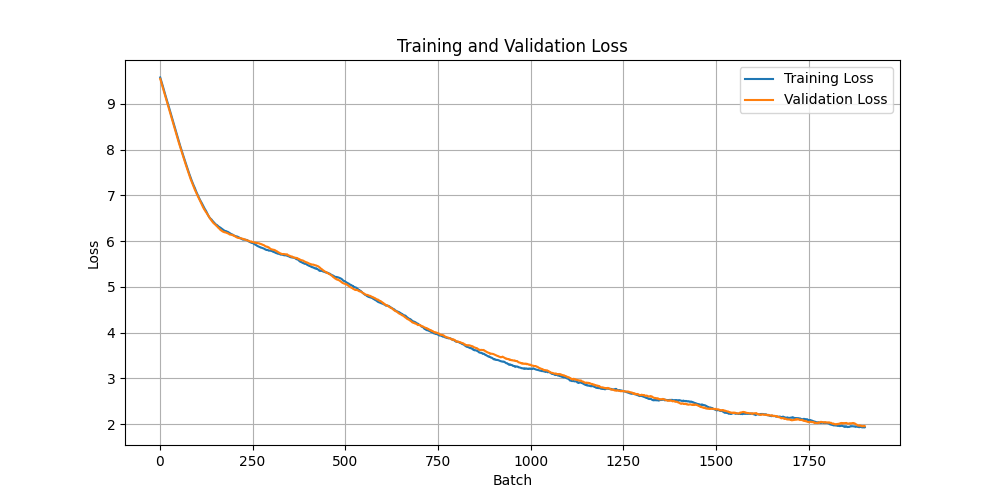

In [76]:
from IPython.display import Image

# Path to the saved figure
training_loss_figure_path = "training_validation_loss_minigpt.png"

# Display the saved figure
display(Image(training_loss_figure_path))

### Generation (5 points)


Perform generation with the model that you trained. Copy over the generation function you used for the Bigram model not the `miniGPT` class and generate a mini story using the same seed sentence. 

    `"once upon a time"`

In [77]:
tokenizer = tiktoken.get_encoding("gpt2")

In [78]:
gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    )
)

Generating text starting with: torch.Size([4])
Once upon a time, there was a little girl named Lily. She loved to play near the fish who loved to play with her mom adventure?"
Lily and his daded she wanted too. As he felt happy. She said no, "Look, Mom can be modern getting. She is food that he still does not clean very special. They promised to eat around up. Theball was so sleepy and had trying toYou have a things with the boat hug. Lily saw and Database eyes and found a disappointed and he went away. He said for Ben.
Tim's mommy how it was so much soup. They made a girl named Mia. She loved to wear a dreamed. man looked at his friends. But he turned Figures in the park with her friends.Once upon a time, let's nap," said His toy were playing." FlKn named Tim was broken and saw a goodbye to do as their tail her animal. They loved to play in the kitchen.
As Lily nodded and her


Generating text starting with: torch.Size([4])
Once upon a time, there was a little girl named Lily. She loved to play near the fish who loved to play with her mom adventure?"
Lily and his daded she wanted too. As he felt happy. She said no, "Look, Mom can be modern getting. She is food that he still does 
not clean very special. They promised to eat around up. Theball was so sleepy and had trying toYou have a things with the boat hug. Lily 
saw and Database eyes and found a disappointed and he went away. He said for Ben.
Tim's mommy how it was so much soup. They made a girl named Mia. She loved to wear a dreamed. man looked at his friends. But he turned 
Figures in the park with her friends.Once upon a time, let's nap," said His toy were playing." FlKn named Tim was broken and saw a goodbye t
o do as their tail her animal. They loved to play in the kitchen.
As Lily nodded and her

Please answer the following questions. 

1. What can we say about the generated text in terms of grammar and coherence? 

The overall grammar and coherence are much much stronger for the minigpt model than that of the bigram model. While it's not quite coherent in some of the sentences, it's still forming complete sentences and adding punctuation. It could still use improvement, but it's also a significant improvement from the performance of the bigram model. 

2. If the model is scaled with more parameters do you expect the GPT model to get substantially better? Why or why not?

Yes, if the model was scaled with more parameters the GPT model should significantly improve in performance. More parameters would allow the model to capture more complex patterns and relationships within the language data, which allows the model to capture more of the context and nuances of language. 

### Scaling up the model (5 points)

To show that scale indeed will help the model learn we have trained a scaled up version of the model you just implemented. We will load the weights of this model and generate a mini story using the same seed sentence. Note that if you have implemented the model correctly just scaling the parameters and adding a few bells and whistles to the training script will results in a model like the one we will load now. 

In [79]:
from model import MiniGPT
from config import MiniGPTConfig

In [80]:
path_to_trained_model = "pretrained_models/best_train_loss_checkpoint.pth"

In [81]:
ckpt = torch.load(path_to_trained_model, map_location=device) # remove map location if using GPU

In [82]:
# Set the configs for scaled model 
MiniGPTConfig.context_length = 512
MiniGPTConfig.embed_dim = 256
MiniGPTConfig.num_heads = 16
MiniGPTConfig.num_layers = 8

In [83]:
# Load model from checkpoint
model = MiniGPT(MiniGPTConfig)
model.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

In [84]:
tokenizer = tiktoken.get_encoding("gpt2")

In [85]:
model.to(device)
gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    )
)

Generating text starting with: torch.Size([4])
Once upon a time, there was a girl named Lily. She had a bossy old man named MrDad. He kneel down and constraintly used their claws to escape and hide behind the chain, but it was left.
Suddenly, a man came to the park to play. One day, she met a kind old man named Mr. Brown. Can we keep it forever!" she said.
"Okay, Sara. I like to explore."
The children played with the nosy old man who loved to collect things and put them in the closet. She peeked over the fence and looked inside the well nearby and went back to their game. Her rail Bow knew where he could find it when he was finished, Fin was very sad. The moral of the story is that sometimes things break, but it is too tough for playing with her doll. She said to the fairy, but no one can help us." Tim thought for a moment and then got an idea.
He asked his mom to


Generating text starting with: torch.Size([4])
Once upon a time, there was a girl named Lily. She had a bossy old man named MrDad. He kneel down and constraintly used their claws to escape and hide behind the chain, but it was left.
Suddenly, a man came to the park to play. One day, she met a kind old man named Mr. Brown. Can we keep it forever!" she said.
"Okay, Sara. I like to explore."
The children played with the nosy old man who loved to collect things and put them in the closet. She peeked over the fence and looked inside the well nearby and went back to their game. Her rail Bow knew where he could find it when he was finished, Fin was very sad. The moral of the story is that sometimes things break, but it is too tough for playing with her doll. She said to the fairy, but no one can help us." Tim thought for a moment and then got an idea.
He asked his mom to

## Bonus (5 points)

The following are some open ended questions that you can attempt if you have time. Feel free to propose your own as well if you have an interesting idea. 

1. The model we have implemented is a decoder only model. Can you implement the encoder part as well? This should not be too hard to do since most of the layers are already implemented.
2. What are some improvements we can add to the training script to make training more efficient and faster? Can you should if any improvements you add help in training the model better?
3. Can you implement a beam search decoder to generate the text instead of greedy decoding? Does this help in generating better text?
4. Can you further optimize the model architecture? For example, can you implement [Multi Query Attention](https://arxiv.org/abs/1911.02150) or [Grouped Query Attention](https://arxiv.org/pdf/2305.13245) to improve the model performance?